# Perceptive Space Take Home Assigment

### Imports

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import astrotools as at
import scipy as sc
import pandas as pd
import mplcursors
from mpl_toolkits.mplot3d import Axes3D


### Defining Constants and Central Body

In [209]:
earth = at.MyWGS84("km") # Earth with units based on km
c = 299792458 * 1e-3 # speed of light in km/s

## Import and Clean GPS Measurements

In [210]:
# import data
df = pd.read_csv('GPS meas.csv')
df['time'] = pd.to_datetime(df['time'])

# sort by x, y, z
xyz_order = {'x': 1, 'y': 2, 'z': 3}
df['xyz_order'] = df['ECEF'].map(xyz_order)
df = df.sort_values(by=['time', 'xyz_order'])
df = df.drop(columns=['xyz_order'])

# extract x, y, z positions and velocities
sat = {}
sat['r_itrf'] = np.array([df[df['ECEF'] == 'x']['position'].values,
                          df[df['ECEF'] == 'y']['position'].values,
                          df[df['ECEF'] == 'z']['position'].values])
sat['v_itrf'] = np.array([df[df['ECEF'] == 'x']['velocity'].values,
                          df[df['ECEF'] == 'y']['velocity'].values,
                          df[df['ECEF'] == 'z']['velocity'].values]) / 1e4
clock_bias = np.array(df['clock'].values[0:-1:3])
date = df[df['ECEF'] == 'x']['time']

### Outlier Cleanup

In [211]:
min_leo = earth.SemimajorAxis + 150 # minimum LEO radius
max_geo = earth.SemimajorAxis + 35786 + 300 # maximum geo radius

sat['r_mag'] = np.linalg.norm(sat['r_itrf'], axis=0)
keep_ind = (sat['r_mag'] >= min_leo) & (sat['r_mag'] <= max_geo)
sat['r_itrf'] = sat['r_itrf'][:, keep_ind]
sat['v_itrf'] = sat['v_itrf'][:, keep_ind]
sat['r_mag'] = sat['r_mag'][keep_ind]
date = date[keep_ind]
clock_bias = clock_bias[keep_ind] * 1e-6

### Date Extraction

In [212]:
# Extract year, month, and day with fractional time
year = date.dt.year.to_numpy()
month = date.dt.month.to_numpy()
day = date.dt.day.to_numpy()
frac = ((date.dt.hour + date.dt.minute / 60 + date.dt.second / 3600) / 24).to_numpy()

CalUTtoJD_vec = np.vectorize(at.CalUTtoJD)
JD = CalUTtoJD_vec(year,month,day,frac*24)
GMST, _ = at.JDtoGMST(JD,0)
N = len(JD)
dt = np.diff(JD) * 86400
day_skip = dt > dt[0] * 5

### Clock Bias Correction

In [213]:
p_corr = c * clock_bias
clock_drift = np.diff(clock_bias) / dt
for i in range(N):
    sat['r_itrf'][:,i] = (np.linalg.norm(sat['r_itrf'][:,i]) - (c * clock_bias[i])) * at.normalize(sat['r_itrf'][:,i])
    if i > 0:
        sat['v_itrf'][:,i] = sat['v_itrf'][:,i] - c * clock_drift[i-1] * at.normalize(sat['r_itrf'][:,i])


### Transformation from ECEF to ECI
Here, we are assuming the ECEF frame being used is the ITRF frame and the assumed ECI frame is J2000

In [214]:
EOP2 = at.parseEOPFile("./astrotools/EOP2long.txt") # inport Earth Orientation Parameters for polar motion rotation
sat['r_j2000'] = np.zeros_like(sat['r_itrf'])
sat['v_j2000'] = np.zeros_like(sat['v_itrf'])
for i in range(len(sat['r_itrf'][0])):
    R_earthrot = at.rot(GMST[i], 3, "degrees").T
    R_nutation = at.RotNutation(JD[i], "UT1").T
    R_precession = at.RotPrecession(JD[i], "UT1").T
    R_polarmotion = at.RotPolarMotion(JD[i], EOP2).T
    full_rot = R_precession @ R_nutation @ R_earthrot @ R_polarmotion
    sat['r_j2000'][:,i] = full_rot @ sat['r_itrf'][:,i]
    sat['v_j2000'][:,i] = full_rot @ sat['v_itrf'][:,i]


## 1. Tracking and Filtering 

### Extended Kalman Filter Parameters

In [215]:
# Initialize process noise covariance matrix (Q)
q1 = 1e-5
q2 = 1e-7
Q = np.diag([q1, q1, q1, q2, q2, q2])

# Initialize measurement noise covariance matrix (R)
# assume 10 meter accuracy in gps
r1 = (10. * 1e-3)**2
# r1 = 1e-4
# assume .5 meter/sec accuracy in gps
r2 = (0.1 * 1e-3)**2
# r2 = 1e-8
R = np.diag([r1, r1, r1, r2, r2, r2])

# Initialize state covariance matrix (P)
# P_est = np.eye(6)
p_var = 1
v_var = 0.1
P_est = np.diag([p_var, p_var, p_var, v_var, v_var, v_var])

### Vector Initialization and Force Model Paramaters

In [216]:
## Initialize estimation array
x_est = np.zeros([6, N]);  
x_est[:, 0] = np.concatenate((sat['r_j2000'][:,0], sat['v_j2000'][:,0]))
dt_min = np.min(dt)


# gravity parameters
max_degree = 4
earth.read_egm('./astrotools/EGM2008_to360.txt', max_degree)
# aerodynamic parameters
Cd = 2.2
sarea = 10 / (1e3)**2 # surface area in km^2

### EKF Loop

In [217]:
for k in range(N-1):
    # Prediction step
    r = np.linalg.norm(x_est[0:3, k])  # Compute the magnitude of the position vector

    f = lambda t,x: at.orbit_ode(t, x, 
                                 earth.mu, gravity="J", 
                                 max_degree=max_degree, Re=earth.SemimajorAxis, 
                                 C=earth.C, S=earth.S, GMST=GMST[k], J=earth.J,
                                 atmosphere="simple",Cd=Cd,sarea=sarea, omega=earth.omega)

    if dt[k] > dt_min * 1e1:
        ns = 1500
    elif dt[k] > dt_min * 3:
        ns = 36
    else:
        ns = 18
    _, x_pred = at.rk4_substeps(f, 0, x_est[:, k], dt[k], num_substeps=ns)

    # Jacobian (F_k) for state transition, initialization
    par2body = np.eye(3) * (-earth.mu / r**3)
    # Loop to modify the par2body matrix
    for i in range(3):
        for j in range(3):
            par2body[i, j] += 3 * earth.mu / r**5 * x_est[i, k] * x_est[j, k]

    # State transition Jacobian F
    F = np.block([[np.zeros((3, 3)), np.eye(3)], [par2body, np.zeros((3, 3))]])
    STM = np.eye((6)) + F * dt[k]
    STM = dt[k] * F
    
    # Covariance prediction
    P_pred = STM @ P_est @ STM.T + Q

    # Kalman Gain
    H = np.eye(6)  # Measurement matrix
    S = H @ P_pred @ H.T + R  # Innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    
    # Measurement update
    z_k = np.concatenate((sat['r_j2000'][:,k+1], sat['v_j2000'][:,k+1]))    
    innovation = z_k - H @ x_pred

    x_est[:,k+1] = x_pred + K @ innovation # Update state estimate
    P_est = (np.eye(6) - K @ H) @ P_pred # Covariance update

### Plotting Orbit (3D)

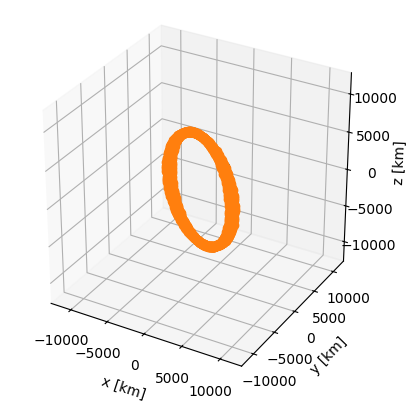

In [218]:
ax = plt.figure().add_subplot(projection="3d")
ax.plot(sat['r_j2000'][0],sat['r_j2000'][1],sat['r_j2000'][2],label="SV Trajectory",marker="*",linestyle='None')
# ax = at.plotsphere(ax,earth.SemimajorAxis)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_zlabel("z [km]")
lim = 2*earth.SemimajorAxis
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])
ax.set_zlim([-lim,lim])
ax.set_aspect('equal')
ax.plot(x_est[0,:],x_est[1,:],x_est[2,:],label="Estimated Trajectory",marker="o",linestyle="None")
plt.show()

### Component Residuals

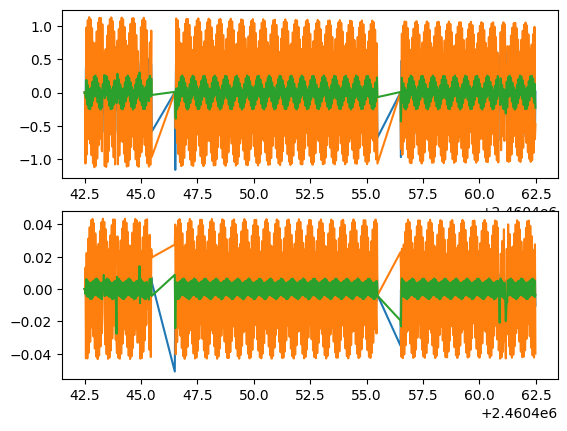

In [219]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].plot(JD, (x_est[0:3,:] - sat['r_j2000'][:,:]).T)
axes[1].plot(JD, (x_est[3:6,:] - sat['v_j2000'][:,:]).T)
plt.show()

### Orbit Energy Plot

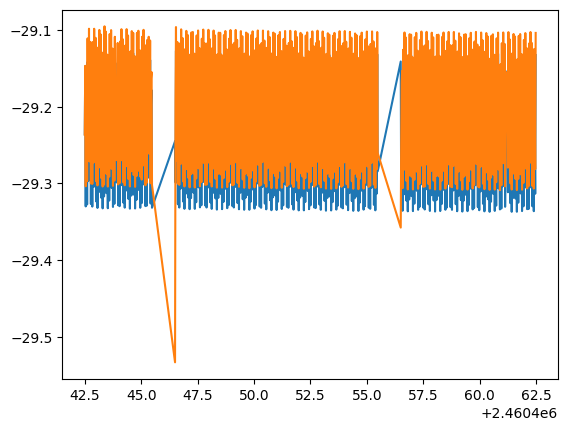

In [220]:
plt.figure()
E = at.orbit_energy(sat['r_j2000'], sat['v_j2000'], earth.mu)
E_est = at.orbit_energy(x_est[0:3,:], x_est[3:6,:], earth.mu)
plt.plot(JD,E)
plt.plot(JD,E_est)
plt.show()

#

## 2. Maneuver Detection

### Using Velocity Magnitude Residuals

In [221]:
v_res = np.linalg.norm(x_est[3:6,:] - sat['v_j2000'], axis=0)
# v_threshold = 0.05  # Threshold for velocity residuals in km/s
v_threshold = np.mean(v_res) + 1.25 * np.std(v_res)
# Initialize arrays to store detection data
man_detect = np.zeros(N, dtype=bool)

# Loop through the time steps separately for maneuver detection
for k in range(N):
    if v_res[k] > v_threshold:
        man_detect[k] = True

# Find indices where maneuvers were detected
maneuver_indices_velocity = np.where(man_detect == True)[0]
print("Maneuvers detected by velocity residuals at time steps:", maneuver_indices_velocity)

Maneuvers detected by velocity residuals at time steps: [114 140 141 572 794]


### Plot Residuals and Maneuver Threshold

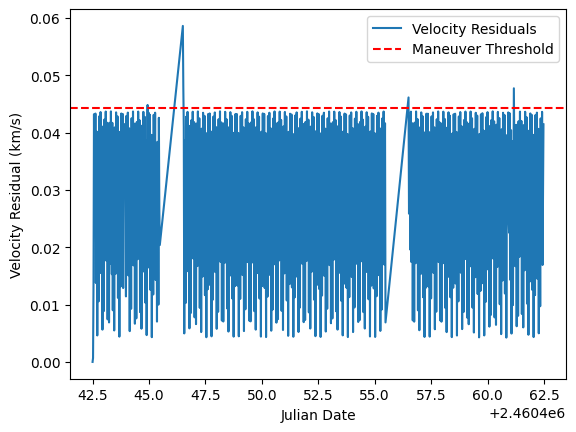

In [222]:
plt.figure()
plt.plot(JD, v_res, label="Velocity Residuals")
plt.axhline(y=v_threshold, color='r', linestyle='--', label="Maneuver Threshold")
plt.xlabel("Julian Date")
plt.ylabel("Velocity Residual (km/s)")
plt.legend()
plt.show()

## 3. Propagate into the Future

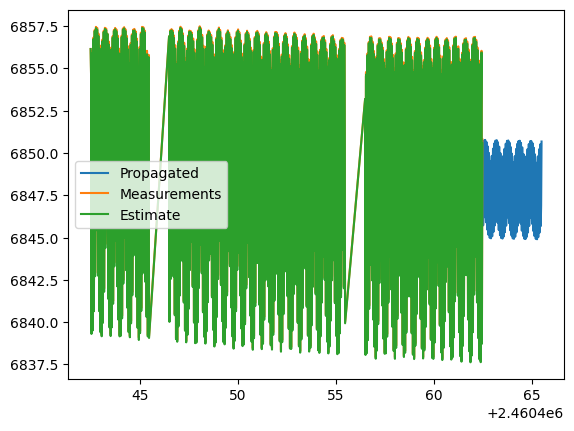

In [223]:
JD_start = JD[-1] + dt[-1] / 86400
JD_end =  JD_start + 3
dt_prop = 1800 # propagation step size of 30 minutes
N_prop = int((JD_end - JD_start)*86400/dt_prop)
JD_prop = np.linspace(JD_start, JD_end, N_prop)
dt_prop = np.diff(JD_prop) * 86400
GMST_prop, _ = at.JDtoGMST(JD_prop,0)

x_prop = np.zeros((6,N_prop))
x_prop[:,0] = x_est[:,-1]

for k in range(N_prop-1):
    # propagate at 60 second intervals, sample at 30 minutes
    f = lambda t,x: at.orbit_ode(t, x, 
                                 earth.mu, gravity="J", 
                                 max_degree=max_degree, Re=earth.SemimajorAxis, 
                                 C=earth.C, S=earth.S, GMST=GMST_prop[k], J=earth.J,
                                 atmosphere="simple",Cd=Cd,sarea=sarea, omega=earth.omega)
    _, x_prop[:,k+1] = at.rk4_substeps(f, 0, x_prop[:,k], dt_prop[k], num_substeps=30) 


r_mag_prop = np.linalg.norm(x_prop[:3], axis=0)
v_mag_prop = np.linalg.norm(x_prop[3:], axis=0)

plt.figure()
plt.plot(JD_prop,r_mag_prop, label='Propagated')
plt.plot(JD,np.linalg.norm(sat['r_j2000'], axis=0), label='Measurements')
plt.plot(JD,np.linalg.norm(x_est[:3], axis=0), label="Estimate")
plt.legend()
plt.show()